In [217]:
import pandas as pd
import numpy as np
import pickle
from collections import Counter, defaultdict
import unidecode
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.tokenize import TreebankWordTokenizer
from lyricsgenius import Genius
import re
import string
import time
from sklearn.preprocessing import StandardScaler
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth
import spotipy.util as util
from sp_client import Spotify_Client

sp = Spotify_Client()


punct = set(string.punctuation)
punct.update({"''", "``", ""})
tokenizer = TreebankWordTokenizer()

genius = Genius('bVEbboB9VeToZE48RaiJwrnAGLz8VbrIdlqnVU70pzJXs_T4Yg6pdPpJrTQDK46p')
genius.verbose = False


stopwords = set(stopwords.words('english'))

path = r'C:\Users\chris\Documents\GitHub\cs4300sp2021-rad338-jsh328-rpp62-cmc447\sample_data/'

## Preprocessing
This section only needs to be run once, and the intermediate outputs can be saved.

In [2]:
df = pd.read_csv(path + "sample5000_SAFApril2019.csv")
lyrics_dict = pickle.load(open(path + 'sample5000_SAFApril2019_lyrics.pkl', 'rb'))
N_DOCS = len(lyrics_dict)

In [3]:
df = df.loc[df.track_id.isin(lyrics_dict)].reset_index(drop = True)
df['primary_artist'] = [unidecode.unidecode(x).split(",")[0] for x in df['artist_name']]

In [121]:
URI_TO_SONG = {row['track_id']: f"{row['artist_name']} | {row['track_name']}" for _, row in df.iterrows()}

In [5]:
df

,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity,primary_artist
0,Soulja Boy,2HXdAom65IM8wY5S2QhHpo,Fresh out the Trap,0.681000,0.796,153936,0.477,0.000000,8,0.5550,-10.670,1,0.3690,130.076,4,0.815,28,Soulja Boy
1,Mokita,1Xy2tuw1Z2RvFiJEI538DT,When I See You,0.460000,0.649,203843,0.568,0.000000,10,0.0933,-10.051,1,0.0496,116.793,4,0.325,64,Mokita
2,Remedy Drive,4ofrzpGb8W70sjzaVrFoh1,I Don't Belong to You,0.143000,0.595,218160,0.758,0.458000,0,0.0601,-6.278,1,0.0583,161.956,4,0.710,15,Remedy Drive
3,Armin van Buuren,37Ph6K7yrjpwHJCBrEFb18,"A State Of Trance (ASOT 853) - Track Recap, Pt. 1",0.183000,0.520,34652,0.632,0.000000,11,0.6500,-10.641,0,0.2280,65.354,4,0.715,6,Armin van Buuren
4,Waka Flocka Flame,3WljEX77ZEkGN8bP3dBY50,Luv Da Gun Sound,0.128000,0.516,215616,0.776,0.000000,7,0.3330,-6.854,1,0.2780,140.058,4,0.527,25,Waka Flocka Flame
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657,August Alsina,6dS5dbyAXpCStP3AU0J3dI,Forever and A Day,0.218000,0.733,174817,0.569,0.000000,11,0.3270,-8.799,1,0.0587,135.026,4,0.808,54,August Alsina
658,Armin van Buuren,2701tttWBrUlNIiuQzZZF4,A State Of Trance (ASOT 889) - Interview with ...,0.383000,0.611,43540,0.578,0.000000,6,0.3530,-10.804,0,0.3280,77.159,4,0.882,10,Armin van Buuren
659,Zé Neto & Cristiano,1fyhyOy6iS9E2NckAzjmTo,Status Que Eu Não Queria - Ao Vivo,0.590000,0.580,153934,0.871,0.000000,4,0.5640,-4.052,1,0.2090,117.622,4,0.911,74,Ze Neto & Cristiano
660,Bon Jovi,4HQMmxKRdEqPWAesuBZyOv,We Don't Run,0.000126,0.442,198333,0.928,0.000004,8,0.3280,-3.660,0,0.0671,156.013,4,0.450,27,Bon Jovi


In [6]:
def make_inv_idx(lyrics_dict, remove_stopwords = True):
    word_to_ix = dict()
    inv_idx = defaultdict(list)
    word_ix = 0
    
    for uri, cnt in lyrics_dict.items():
        for word, val in cnt.items():
            if remove_stopwords:
                if word not in stopwords and word.isalpha():
                    inv_idx[word].append((uri, val))
                    if word not in word_to_ix:
                        word_to_ix[word] = word_ix
                        word_ix += 1
            else:
                inv_idx[word].append((uri, val))
                if word not in word_to_ix:
                    word_to_ix[word] = word_ix
                    word_ix += 1
                    
    return inv_idx, word_to_ix

In [7]:
inv_idx, word_to_ix = make_inv_idx(lyrics_dict)

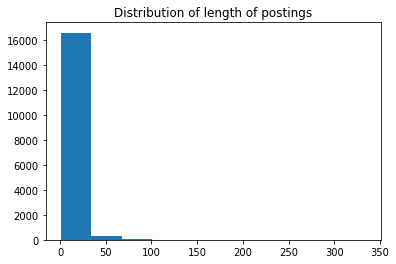

count    17004.000000
mean         3.985474
std         13.084081
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        334.000000
dtype: float64

In [8]:
len_postings = [len(v) for v in inv_idx.values()]
plt.hist(len_postings)
plt.title("Distribution of length of postings")
plt.show()
pd.Series(len_postings).describe()

In [9]:
def compute_idf(inv_idx, min_df=1, max_df_ratio=1):
    idf_dict = dict()
    for word, posting in inv_idx.items():
        df = len(posting)
        if (df >= min_df) and (df/N_DOCS <= max_df_ratio):
            idf_dict[word] = np.log2(N_DOCS/(1+df))
    return idf_dict

In [10]:
idf_dict = compute_idf(inv_idx)

In [11]:
def compute_song_norms(inv_idx, idf_dict):
    song_norms_dict = dict()
    for word, postings in inv_idx.items(): #iter through each token in corpus
        for uri, tf in postings: #iter through each doc token appears in 
            song_norms_dict[uri] = song_norms_dict.get(uri,0) + (tf*idf_dict.get(word, 0))**2
    return {k:np.sqrt(v) for k,v in song_norms_dict.items()}

In [12]:
song_norms_dict = compute_song_norms(inv_idx, idf_dict)

## Actual functions

###  Lyrics cosine similarity

In [250]:
def strip_name(name):
    for s in ["-", "(", "feat."]:
        ix = name.find(s)
        if s != -1:
            name = name[:ix].strip()
    return name

def match(a, b):
    a = unidecode.unidecode(a).lower()
    b = unidecode.unidecode(b).lower()
    return (a in b) or (b in a)

def retrieve_lyrics(query_name, query_artist):
    while True:
        try:
            s = genius.search_song(query_name, query_artist, get_full_info = False)
            break
        except:
            pass
    if s:
        if match(query_artist, s.artist):
            song_lyrics = s.to_text().lower()
            song_lyrics = re.sub(r'[\(\[].*?[\)\]]', '', song_lyrics)
            tokens = [t for t in tokenizer.tokenize(song_lyrics) if t not in punct]
            cnt = Counter(tokens)
            return cnt
        else:
            print(f"{query_artist}: {query_name} not found on Genius.")            
    else:
        print(f"{query_artist}: {query_name} not found on Genius.")

In [254]:
def lyrics_sim(query, inv_idx, idf_dict, song_norms_dict, n_results = 10):
    """
    query: artist | name
    if final result, just return names of songs
    """
    start = time.time()
    n_results = min(n_results, len(song_norms_dict))
    query_artist, query_name = [x.strip() for x in query.split("|")]
    query_name = strip_name(query_name)
    song_lyrics_cnt = retrieve_lyrics(query_name, query_artist)
    if not song_lyrics_cnt:
        return
    
    query_tf_dict = song_lyrics_cnt #query tf values
    
    query_tfidf = dict()
    query_norm = 0
    for t in query_tf_dict:
        if t in idf_dict: #only add token to tfidf dict if idf value exists
            tfidf = query_tf_dict[t] * idf_dict[t]
            query_tfidf[t] = tfidf
            query_norm += tfidf**2
    query_norm = np.sqrt(query_norm)
    
    doc_scores = dict()
    for t in query_tfidf: #all query tokens guaranteed to be in inv_index from above for-loop and previous precomputation cell
        for doc_id, tf in inv_idx[t]:
            doc_scores[doc_id] = doc_scores.get(doc_id, 0) + (tf*idf_dict[t] * query_tfidf[t]) #doc_tfidf * query_tfidf
    for doc_id in doc_scores:
        doc_scores[doc_id] /= (song_norms_dict[doc_id] * query_norm) #normalize by doc_norm * query_norm
    
    end = time.time()
    ranked = sorted([(round(doc_scores[x], 2), URI_TO_SONG[x]) for x in doc_scores], key = lambda x: (-x[0], x[1]))
    print(f"{n_results} results retrieved in {round(end-start, 2)} seconds")
    
    first_result_artist, first_result_name = [x.strip() for x in ranked[0][1].split("|")]
    if match(query_artist, first_result_artist) and match(query_name, strip_name(first_result_name)): #song in dataset, don't want to return
        return ranked[1:n_results+1]
    else:
        return ranked[:n_results]

In [15]:
lyrics_sim("Post Malone | Circles", inv_idx, idf_dict, song_norms_dict)

10 results retrieved in 0.96 seconds


[(0.45, 'MISSIO | I Run To You'),
 (0.27, "Bon Jovi | We Don't Run"),
 (0.22, 'Prezi | Family (feat. Tree Thomas & Mozzy)'),
 (0.18, 'Shawn Mendes | Where Were You In The Morning? - Remix'),
 (0.17, 'Call It Home | Driftwood (feat. Landon Tewers)'),
 (0.17, 'MERLOT | Bad For You'),
 (0.16, 'William Black | Letting Go - Miles Away Remix'),
 (0.16, 'William Black | Letting Go - PRXZM Remix'),
 (0.15, 'Kehlani | Footsteps (feat. Musiq Soulchild)'),
 (0.14, 'Des Rocs | Let Me Live / Let Me Die')]

In [16]:
lyrics_sim("Bon Jovi | We Don't Run", inv_idx, idf_dict, song_norms_dict)

10 results retrieved in 0.82 seconds


[(0.34, 'MISSIO | I Run To You'),
 (0.13, 'The Academic | Northern Boy'),
 (0.12, 'Prezi | Family (feat. Tree Thomas & Mozzy)'),
 (0.12, 'Sam Smith | Fire On Fire'),
 (0.11, 'Jack Hellman | Crisscrossed - JackEL Remix'),
 (0.11, 'Lissie | Castles'),
 (0.11, 'The Vaccines | Surfing in the Sky'),
 (0.1, 'August Alsina | Forever and A Day'),
 (0.09, 'Adam K | Twilight vs Breathe (WYM205)'),
 (0.09, 'Chris Orrick | Jealous of the Sun')]

### Preprocessing

In [265]:
AF_COLS = ['acousticness', 'danceability',
       'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence']

def get_af_matrix_data(df):
    af_ix_to_song = [row.to_dict() for _, row in df.iterrows()]    
    scaler = StandardScaler()
    af_matrix = scaler.fit_transform(df.loc[:, AF_COLS].to_numpy()) #need to scale data, otherwise all scores are .99
    af_song_norms = np.linalg.norm(af_matrix, axis = 1)
    return af_ix_to_song, af_matrix, af_song_norms, scaler

In [266]:
af_ix_to_song, af_matrix, af_song_norms, scaler = get_af_matrix_data(df.rename(columns = {'artist_name':'artist', 'track_name': 'name'}))

### Audio features similarity

In [269]:
def get_song_uri(query_artist, query_name):
    search_results = sp.search(f"{query_artist} {query_name}")['tracks']['items']
    if not search_results:
        print("Song not found on Spotify.")
    else:
        for d in search_results:
            artists = ",".join([x['name'] for x in d['artists']])
            if match(query_artist, artists) and match(query_name, d['name']):
                return d['uri']
    print("Song not found on Spotify")

def get_audio_features(uri, artist = None, name = None):
    data = sp.audio_features(uri)[0]
    if not data:
        print("Song not found on Spotify")
    if not artist or not name:
        track_info = sp.track(uri)
        artist = ", ".join([x['name'] for x in track_info['artists']])
        name = track_info['name']
    af = {k:data[k] for k in AF_COLS}
    af['artist'] = artist
    af['name'] = name
    af['uri'] = data['uri']
    return af

def af_sim(query, af_matrix, af_song_norms, af_ix_to_song, scaler, n_results = 10):
    """
    if final result, just return names of songs
    """
    start = time.time()
    n_results = min(n_results, len(af_song_norms))
    
    query_artist, query_name = [x.strip() for x in query.split("|")]
    query_name = strip_name(query_name)
    query_uri = get_song_uri(query_artist, query_name)
    if not query_uri:
        return
    af = get_audio_features(query_uri, query_artist, query_name)
    if not af:
        return
    query_vec = scaler.transform(np.array([af[x] for x in AF_COLS]).reshape(1, -1))
    query_norm = np.linalg.norm(query_vec)
    
    scores = af_matrix.dot(query_vec.squeeze())/(query_norm * af_song_norms)
    ranked = np.argsort(-scores)
    
    i = ranked[0]
    
    first_result_artist = af_ix_to_song[i]['artist']
    first_result_name = af_ix_to_song[i]['name']
    

    if match(query_artist, first_result_artist) and match(query_name, strip_name(first_result_name)): #song in dataset, don't want to return
        ranked = ranked[1:n_results+1]
    else:
        ranked = ranked[:n_results]
    end = time.time()
    print(f"{n_results} results retrieved in {round(end-start, 2)} seconds")
    return [(round(scores[i],2), f"{af_ix_to_song[i]['artist']} | {af_ix_to_song[i]['name']}") for i in ranked]

In [270]:
af_sim('Shaun Frank | Bon Appétit (feat. YA-LE)', af_matrix, af_song_norms, af_ix_to_song, scaler)

10 results retrieved in 0.14 seconds


[(0.93, 'Ookay | Help Me Out'),
 (0.92, 'Crainaz | No Pressure (Remix)'),
 (0.91, 'Carly Moffa | Let the Lion Out'),
 (0.89, 'Cody Johnson | Noise'),
 (0.89, 'Jhay Cortez | Están Pa´ Mí'),
 (0.87,
  'Quando Rondo | Forever (feat. YoungBoy Never Broke Again and Shy Glizzy)'),
 (0.87,
  "Chromeo | Don't Sleep (feat. French Montana & Stefflon Don) - EDX's Miami Sunset Remix"),
 (0.87, 'Luis Jara | Enamorado (Remix)'),
 (0.86, 'Elephante | All Over Again (Fluencee Remix)'),
 (0.86, 'Sigala | Somebody')]